In [3]:
%matplotlib inline
import pylab 
from scipy.stats.stats import pearsonr   as corr
import numpy as np
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import sklearn.feature_selection as sel
from matplotlib import cm as c
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from numpy.linalg import norm
from sklearn.neighbors import NearestNeighbors as NN
from scipy import stats
from sklearn import svm
from sklearn.model_selection import KFold
cm=plt.get_cmap('nipy_spectral') # for the plotting

/home/andreas/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
def findtr(d,target,var_tr):
    ind2=list(d.columns)
    ind2.remove('GasCum360')
    ind2.remove('OilCum360')
    minv=20
    min_ind="bla"
    n=0
    var=20
    l=len(d)
    print()
    v=np.var(d[target])
    print('var: '+str(v))
    print('--------------------------------')
    for indexx in ind2:
        d=d.sort_values(indexx)
        in_var=20
        in_n=0
        for i in range(2,l-2):
            var=(np.var(d.iloc[:i][target])*i+np.var(d.iloc[i:][target])*(l-i))/l
            if var < in_var:
                in_var=var
                in_n=i
        if in_var < minv:
            minv=in_var
            min_ind=indexx
            n=in_n
        if in_var< v*var_tr: #and np.abs(d[target].corr(d[indexx])) < 0.25:
            print('---------------------')
            print(indexx)
            print('index:     '+str(n))
            print('threshold: ' + str(d.iloc[n][indexx])) 
            print('var:       ' + str(in_var))
            print('corr:      '+str(d[target].corr(d[indexx])))
    return [minv,min_ind,n,d[target].corr(d[min_ind])]

In [5]:
def model(d,AL=0.05):
    ind=list(d.columns)
    ind.remove('Zone')
    ind.remove('GasCum360')
    ind.remove('OilCum360')
    ind.append('GasCum360')
    ind.append('OilCum360')
  
    x=d.loc[:,ind]
    #########################
    x=np.array(x) 
    yg=x[:,43]# change for oil/gas pred
   
    ## cut off target   
    a=x[:,:42]
     # normalize the data  
    scaler = StandardScaler()
    X=np.array(scaler.fit_transform(a))
     
    pca = PCA()
    pca.fit(X)
    xx=pca.transform(X)
    selector = sel.VarianceThreshold(threshold=0.1) # features with variances lower than this  will be removed# normal value_0.5
    xx=selector.fit_transform(xx)
    
    p_vals=sel.f_regression(xx,yg)[1]
    F=sel.f_regression(xx,yg)[0]
    
   
    for i in range(len(p_vals)):## not important
        if np.isnan(p_vals[i]):
            p_vals[i]=2# secure handilng for n small
       
    sign_features_ind=[]
    sign_features_ind=[i for i in range(len(p_vals)) if p_vals[i] < AL] # indices of the significant features
    xx2=xx[:,sign_features_ind]### use only significant features for linear model
    XX=sm.add_constant(xx2)
    model=sm.OLS(yg,XX)
    result=model.fit()
    resids=result.resid
    params=result.params

    ############################# hist
    f, axarr = plt.subplots(ncols=1,nrows=2,sharex=True)
    
    normd=np.random.normal(0,np.std(resids),len(d))
    #div=len(d)
    bin=[i/4 for i in range(-5,12)]
    axarr[0].hist(resids)
    axarr[0].set_title('Resisuals')
    axarr[1].hist(normd)
    axarr[1].set_title('normal Sample of same size')
    
    pred=np.dot(XX,params)
    plt.figure() 
    plt.scatter(pred,resids)# high ones are underestimated
    plt.title('residuals vs fitted')
    plt.xlabel('fitted')
    print(result.summary())
    print('var: ' +str(np.var(yg)))# 0.76
    print('var res: ' +str(np.var(resids)))# AL=0.05 0.2458
    print(stats.kstest(resids/np.std(resids),'norm')) 
    plt.figure()
    stats.probplot(resids, dist="norm",plot=plt)
   
    

In [57]:
df=pd.read_csv('partitionned_train_final.csv',sep=',')
df=df.loc[:,'API':]
rows1=df[~df['Nbr_Stages'].isnull()].index
rows2=df[df['Nbr_Stages'].isnull()].index
df1=df.loc[rows1,:] #362 lines
df2=df.loc[rows2,:]#98 lines

df20=df2[df2['group']==0].copy()
df10=df1[df1['group']==0].copy()
df21=df2[df2['group']==1].copy()
df11=df1[df1['group']==1].copy()
df22=df2[df2['group']==2].copy()
df12=df1[df1['group']==2].copy()

print(len(df1))
print(len(df2))



362
98


# KS Tests to check whether target variables of 98 lines and 362 lines come from the same distribution or not.

## Group 0
df10: 85 members

df20: 42 members

### Oil

In [22]:
print(np.var(df10['OilCum360'])) # similar var
print(np.var(df20['OilCum360']))

1.58686614918
1.60949980811


In [30]:
stats.ks_2samp(df10['OilCum360'],df20['OilCum360']) # not the same

Ks_2sampResult(statistic=0.31708683473389354, pvalue=0.0051767049157084178)

### Gas

In [21]:
print(np.var(df10['GasCum360']))# similar var
print(np.var(df20['GasCum360']))

0.161423803927
0.150368335791


In [31]:
stats.ks_2samp(df10['GasCum360'],df20['GasCum360']) # can be same , but low var anyway

Ks_2sampResult(statistic=0.1380952380952381, pvalue=0.62446591091210413)

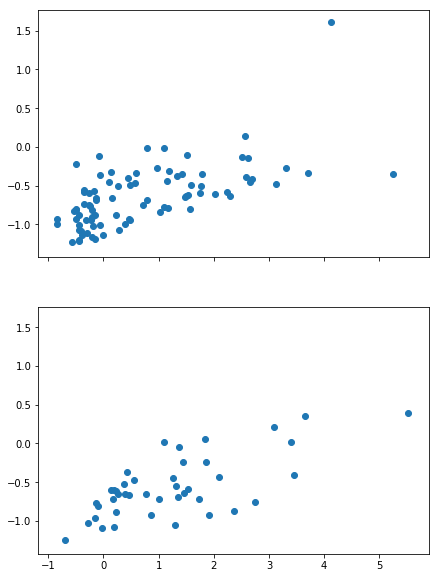

In [52]:
f, axarr = plt.subplots(ncols=1,nrows=2,sharex=True,sharey=True)
f.set_figheight(10)
f.set_figwidth(7)
axarr[0].scatter(df10['OilCum360'],df10['GasCum360'])
axarr[1].scatter(df20['OilCum360'],df20['GasCum360'])
#not very different ( use same scale)

## Group 1



In [20]:

print(len(df11))
print(len(df21))

116
26


### Oil

print(np.var(df11['OilCum360'])) # similar var
print(np.var(df21['OilCum360']))

In [53]:
stats.ks_2samp(df11['OilCum360'],df21['OilCum360']) # is the same

Ks_2sampResult(statistic=0.11007957559681698, pvalue=0.9471796397803578)

## Gas

In [32]:
print(np.var(df11['GasCum360'])) # different var
print(np.var(df21['GasCum360']))

0.193073042644
0.115628419808


In [33]:
stats.ks_2samp(df11['GasCum360'],df21['GasCum360']) # could  be same, but low var anyway

Ks_2sampResult(statistic=0.19496021220159143, pvalue=0.35713459619595606)

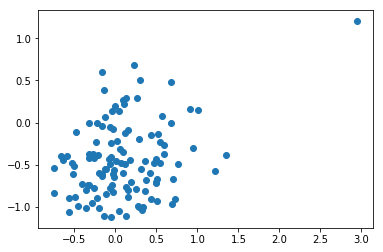

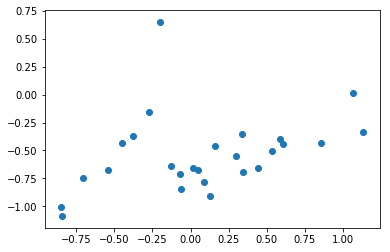

In [46]:
plt.scatter(df11['OilCum360'],df11['GasCum360'])
plt.figure()
plt.scatter(df21['OilCum360'],df21['GasCum360'])
#not very different

## Group 2

In [34]:
print(len(df12))
print(len(df22))

161
30


## Oil

In [35]:
print(np.var(df12['OilCum360'])) # different, but very low
print(np.var(df22['OilCum360']))

0.0714850494607
0.034806934187


In [36]:
stats.ks_2samp(df12['OilCum360'],df22['OilCum360']) # can  be same, but low var anyway

Ks_2sampResult(statistic=0.13913043478260867, pvalue=0.67876788837442348)

## Gas

In [38]:
print(np.var(df12['GasCum360'])) #very different, 
print(np.var(df22['GasCum360']))

0.850496235268
2.50546431314


In [40]:
stats.ks_2samp(df12['GasCum360'],df22['GasCum360']) # is different

Ks_2sampResult(statistic=0.39275362318840579, pvalue=0.00052354759109102462)

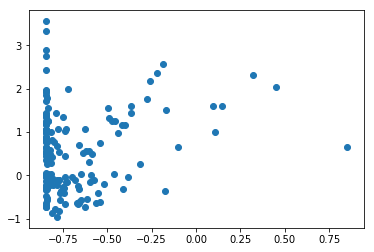

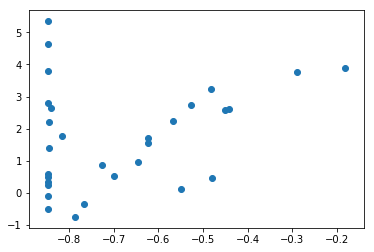

In [44]:
plt.scatter(df12['OilCum360'],df12['GasCum360'])
plt.figure()
plt.scatter(df22['OilCum360'],df22['GasCum360'])
# does not seem amazingly different.

## Conclusion:
It seems that, even if for some cases, the KS test shows that the 98 lines come from a different distribution, it might be better to leave the 98 lines with the others, because otherwise the number of members in each linear model becomes to low to make a significant predication. Given that in the cases where the distributions are not the same, the variances are high ( 98 lines group) ( in one case even higher than 362 lines group), we should not leave the 98 lines alone, at least not for a segmented linear model, because the numbers will be too low at the end. Our hope is, that in those cases, even if the target dsitribution is different, the linear dependencies betweeen expl. vars and target is simimilar for both group of lines ( 362 and 98). **when we have the models on the 460 lines, check the explained variance and see how good the model fits the rowgroup**

## addition: looks like we have to cut off one more group from group 2